In [1]:
!pip install prophet

In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


In [3]:
# Upload your Excel file manually in Colab or update the path if using Google Drive
df = pd.read_excel("Sales_Forecasting_Dataset.xlsx")
df.head()


,Month,Marketing_Spend,CPC,Return_Rate,Competitor_Pricing_Index,Season,Units_Sold,Revenue
0,2021-01-01,27483.57,0.82,0.069,81,2,1737,69480
1,2021-02-01,24308.68,0.60,0.093,108,3,1644,65760
2,2021-03-01,28238.44,0.67,0.031,71,4,2143,85720
3,2021-04-01,32615.15,0.82,0.082,72,5,1715,68600
4,2021-05-01,23829.23,0.87,0.071,106,6,1539,61560


In [4]:
df_prophet = df[['Month', 'Units_Sold']].rename(columns={'Month': 'ds', 'Units_Sold': 'y'})


In [5]:
model = Prophet(yearly_seasonality=True)
model.fit(df_prophet)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp36l0g8g/vgqtfv6o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp36l0g8g/1f9kr4y8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19893', 'data', 'file=/tmp/tmpp36l0g8g/vgqtfv6o.json', 'init=/tmp/tmpp36l0g8g/1f9kr4y8.json', 'output', 'file=/tmp/tmpp36l0g8g/prophet_modeld76bjbao/prophet_model-20250414152537.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:25:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:25:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [6]:
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)


,ds,yhat,yhat_lower,yhat_upper
36,2024-01-01,1755.207322,1621.404139,1900.135825
37,2024-02-01,1904.477910,1769.016150,2048.425302
38,2024-03-01,2122.000608,1972.915582,2265.644010
39,2024-04-01,1577.183445,1439.655422,1717.559779
40,2024-05-01,1350.382719,1206.424423,1498.333138
41,2024-06-01,1703.496043,1559.967812,1857.308339
42,2024-07-01,2007.368417,1860.680339,2157.557201
43,2024-08-01,1453.735158,1316.981195,1598.489670
44,2024-09-01,1691.796358,1547.268317,1839.778698
45,2024-10-01,1732.097253,1581.886195,1873.849470


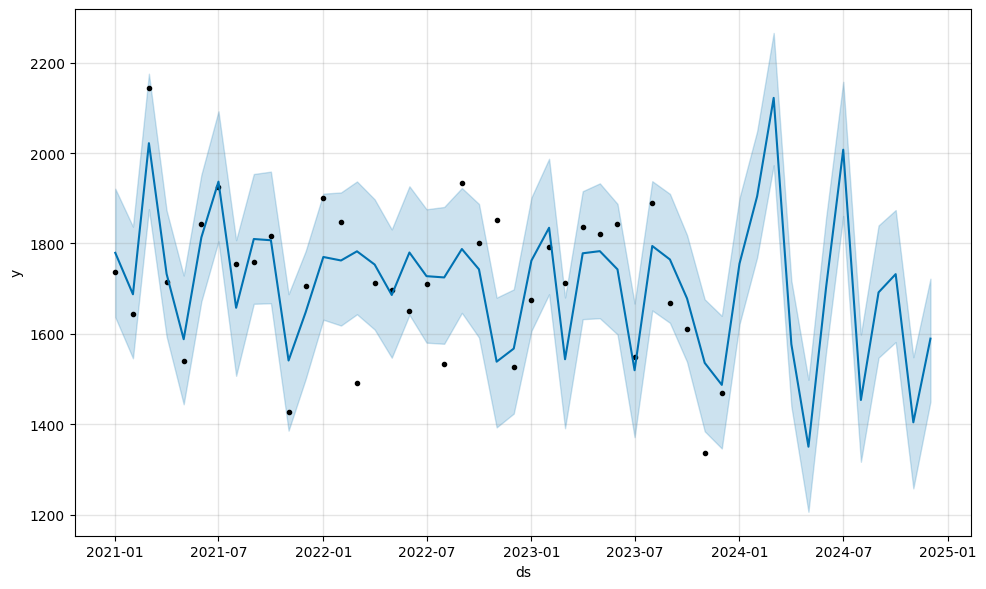

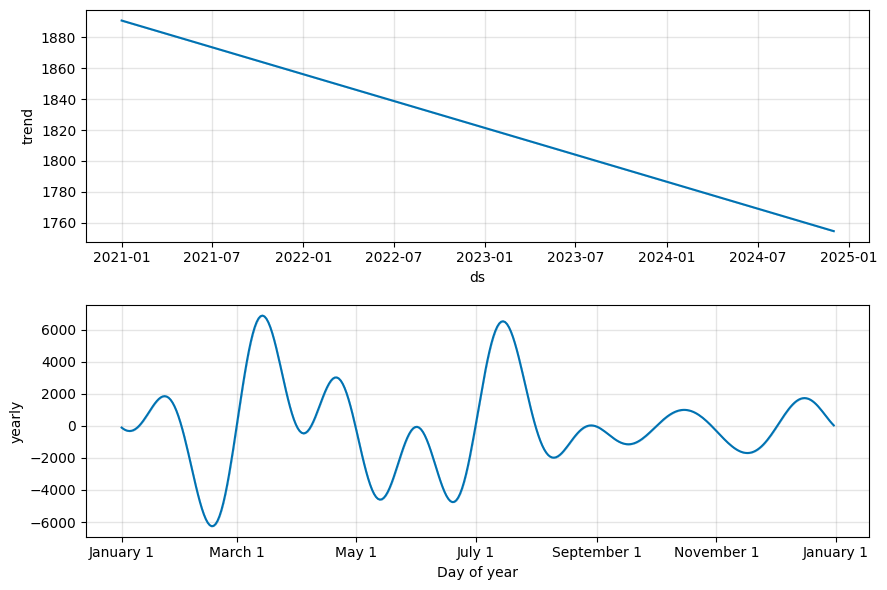

In [7]:
fig1 = model.plot(forecast)
plt.show()

fig2 = model.plot_components(forecast)
plt.show()


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merge actuals with forecast
merged = forecast[['ds', 'yhat']].merge(df_prophet, on='ds', how='left').dropna()

# Metrics
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
mape = np.mean(np.abs((merged['y'] - merged['yhat']) / merged['y'])) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 86.02
RMSE: 112.49
MAPE: 5.12%


In [9]:
# Merge forecast with original features for Power BI
merged_df = pd.merge(forecast[['ds', 'yhat']], df, left_on='ds', right_on='Month', how='left')

# Rename columns for Power BI
merged_df = merged_df.rename(columns={
    'ds': 'Date',
    'yhat': 'Forecast_Units_Sold',
    'Units_Sold': 'Actual_Units_Sold',
    'Revenue': 'Actual_Revenue'
})

# Compute Forecast_Revenue
merged_df['Forecast_Revenue'] = merged_df['Forecast_Units_Sold'] * 40

# Export to CSV
merged_df.to_csv('Sales_Forecasting_PowerBI_Data.csv', index=False)
